# Stock Analysis Using Stocker

We start by importing all the necessary libraries.

In [1]:
# Command for plotting in the notebook
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from stocker import Stocker

# Creating our Stock Object

In [4]:
mothersumi= Stocker(ticker = 'MOTHERSUMI', exchange = 'NSE')

MOTHERSUMI Stocker Initialized. Data covers 1998-03-20 to 2018-02-20.


# Plotting Stock History

The start and end dates are editable.

In [5]:
stock_history = mothersumi.stock
stock_history.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),ds,Adj. Close,Adj. Open,y,Daily Change
4785,2018-02-14,360.8,361.90,353.5,356.0,357.25,4850146.0,17349.59,2018-02-14,357.25,360.8,357.25,-3.55
4786,2018-02-15,358.0,358.00,340.1,342.0,341.20,5807693.0,20054.01,2018-02-15,341.20,358.0,341.20,-16.80
4787,2018-02-16,343.9,344.00,319.1,327.0,326.75,13368026.0,43687.26,2018-02-16,326.75,343.9,326.75,-17.15
4788,2018-02-19,327.0,333.80,320.6,327.7,327.40,3457333.0,11353.40,2018-02-19,327.40,327.0,327.40,0.40
4789,2018-02-20,327.7,329.95,323.1,326.2,325.80,2346083.0,7644.14,2018-02-20,325.80,327.7,325.80,-1.90


Maximum Adj. Close = 536.45 on 2015-07-20.
Minimum Adj. Close = 210.80 on 2016-02-25.
Current Adj. Close = 325.80 on 2018-02-20.



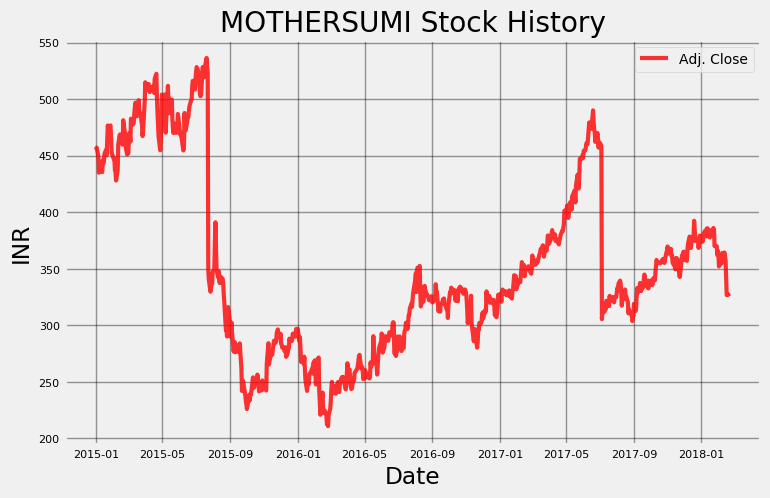

In [6]:
mothersumi.plot_stock(start_date = '2015-01-01')

# Calculate whether you made a profit or a loss 

Here we use 'buy and hold' method from stocker. We specify the number of shares, the start date and the end date, and it calculates profit(if you're lucky enough) or a loss based on the number of shares that you hold.

MOTHERSUMI Total buy and hold profit from 2018-01-22 to 2018-02-09 for 300 shares = $-7215.00


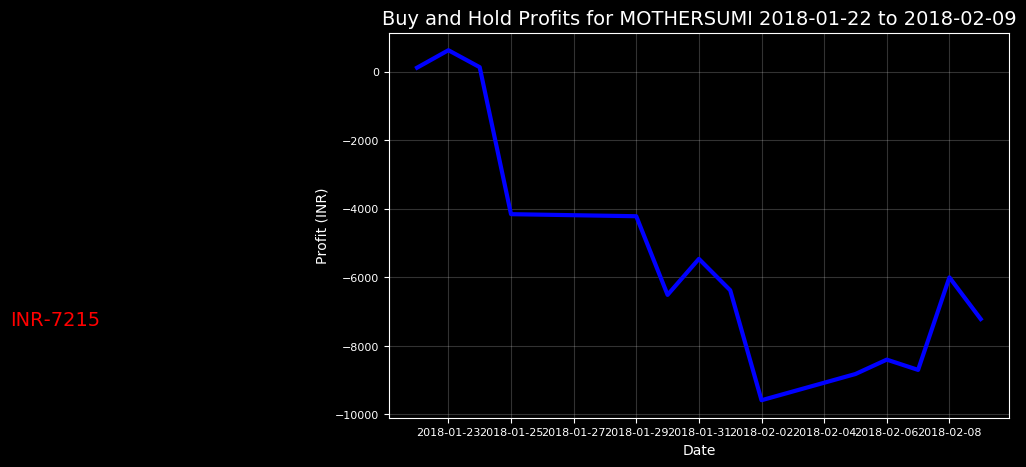

In [7]:
mothersumi.buy_and_hold(start_date ='2018-01-22', end_date = '2018-02-09', nshares = 300)

# Creating prophet models

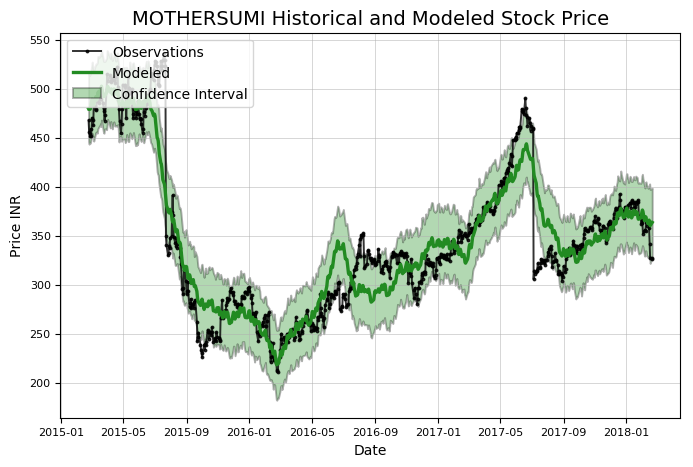

In [8]:
model, model_data = mothersumi.create_prophet_model()

Plotiing the weekly and monthly trend components.

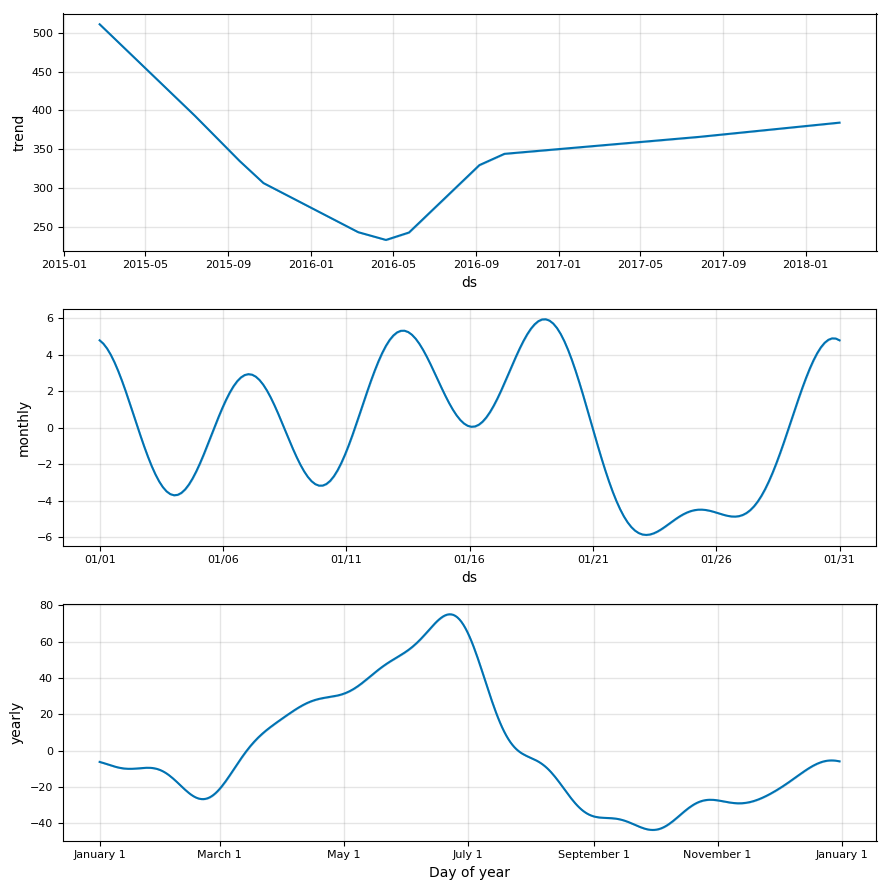

In [9]:
model.plot_components(model_data)
plt.show()

# Changepoint Date Analysis

This helps us observe the dates where prices changed significantly. 


Changepoints sorted by slope rate of change (2nd derivative):

          Date  Adj. Close     delta
309 2016-05-25      265.70  1.129432
285 2016-04-21      273.10  1.072120
380 2016-09-06      323.80 -0.902367
166 2015-10-23      241.55  0.725347
404 2016-10-13      321.70 -0.647634


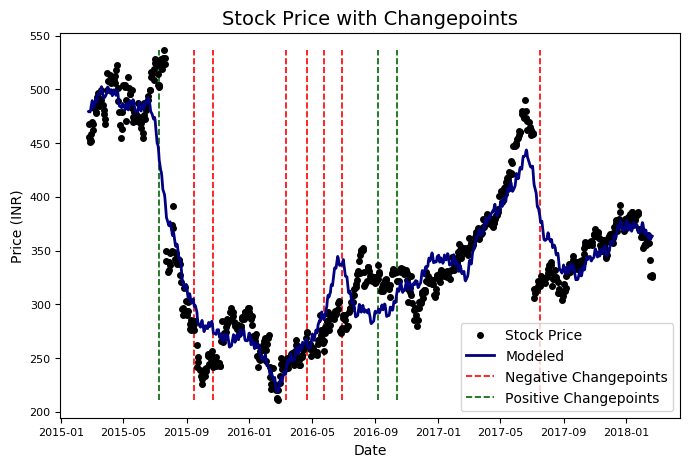

In [10]:
mothersumi.changepoint_date_analysis()

The above graph depicts the possible correlation between related google search trends and the changepoints, but I dont think there are any useful inferences here(except the last changepoint, not surprising at all)

# Predictions

Now that we have analyzed the stock, the next question is where is it going? For that we will have to turn to predictions! 

Predicted Price on 2018-07-20 = INR407.03


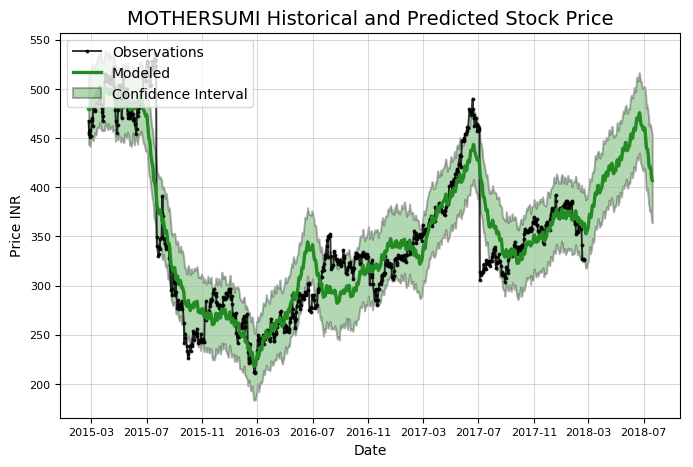

In [11]:
model, model_data = mothersumi.create_prophet_model(days = 150)

# Now evaluating our predictions

For our predictions to be meaningful, we must evaluate them on real data.

One way to do this is set aside some historical data as a test set and use data from further back as our training set. In the default evaluation method, we test using the past year and train on the 3 years prior to the test period.

To quantify the accuracy of our predictions, we can find the average rupee error on both the testing and training data, the percentage the actual price was in the predicted confidence interval, and the percentage of times we predicted the correct direction for the stock.

C:\Users\133924\Documents\Hitachi Consulting\Financial Analytics\stocker\stocker.py:522: RuntimeWarning: invalid value encountered in sign
  test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1



Prediction Range: 2017-02-20 to 2018-02-20.

Predicted price on 2018-02-17 = INR401.45.
Actual price on    2018-02-16 = INR326.75.

Average Absolute Error on Training Data = INR15.00.
Average Absolute Error on Testing  Data = INR54.66.

When the model predicted an increase, the price increased 52.27% of the time.
When the model predicted a  decrease, the price decreased  42.98% of the time.

The actual value was within the 80% confidence interval 59.51% of the time.


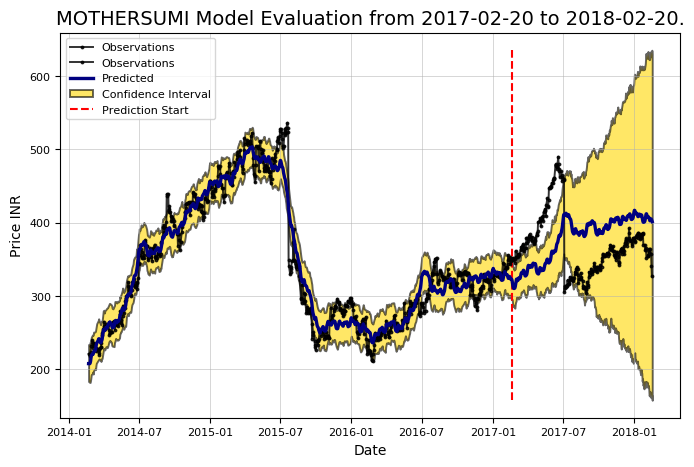

In [12]:
mothersumi.evaluate_prediction()

The predictions are not very good clearly. We need to tweak some scale parameters to change how much weight the model gives to shift in data.

# Changepoint Prior Scale Selection

The changepoint prior scale represents the amount of weight given to the changepoints in the model. This can be used to control overfitting vs underfitting. A higher prior will create a model with more flexibility and more emphasis on the changepoints. This can lead to overfitting because the model will closely follow the training data. Lowering the prior decreases the model flexibility which can cause the opposite problem underfitting. This occurs when our model does not follow the training data closely enough and fails to learn the underlying relationships.

We can use two methods and choose our scale whatever works best for us, our aim being the prediction being on the right side most of the time

First, a graphical comparison. We assign some range of priors to get a feel of how they affect the model.

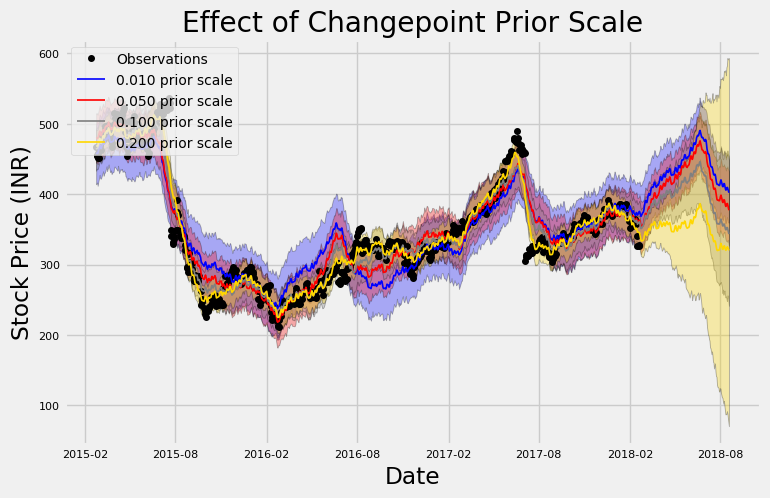

In [13]:
mothersumi.changepoint_prior_analysis(changepoint_priors=[0.01, 0.05, 0.1, 0.2])

Next, a quantitative comparison. The changepoint prior validation method is designed to provide numerical backing. We are testing from 2017-02-12 to 2018-02-12, so we need to make sure to use a different validation range. We will select two years prior to the testing date range. The model will be trained on the three years prior to the validation period.


Validation Range 2016-02-01 to 2017-03-01.

     cps  train_err  train_range    test_err  test_range
0  0.001  67.781792   199.750963  186.165624  199.758413
1  0.050  22.231196    73.934955  296.098455  150.687997
2  0.100  13.480754    47.020503  200.568475  464.974392
3  0.200  11.866929    42.543084  227.795634  617.658505


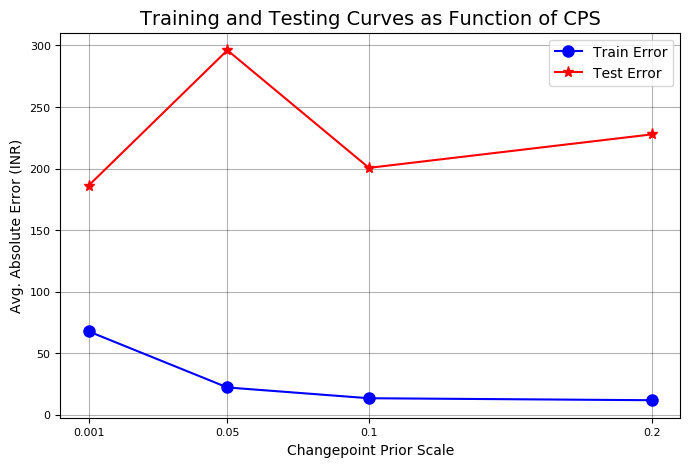

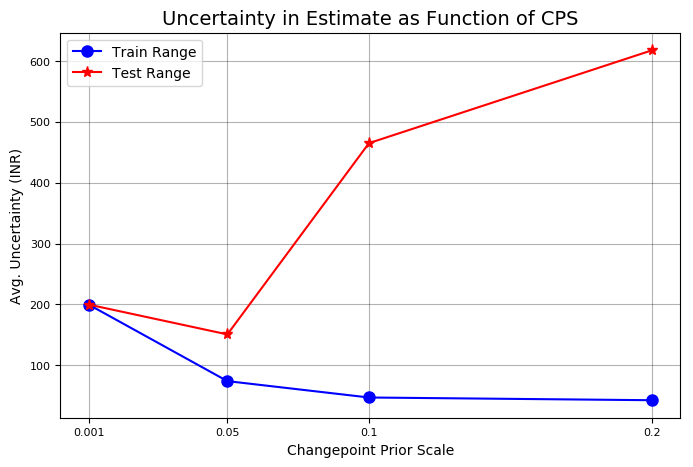

In [14]:
mothersumi.changepoint_prior_validation(start_date = '2016-02-01', end_date = '2017-03-01', changepoint_priors=[0.001, 0.05, 0.1, 0.2])

Refining the model using different cps, as we can see the error decreases as we increase the priors.


Validation Range 2014-02-03 to 2015-04-30.

     cps  train_err  train_range    test_err  test_range
0  0.001  22.342534    71.878282  155.916995   72.093671
1  0.050  13.385184    43.457400   94.896329   74.546581
2  0.100  12.247810    40.601586  103.288631  112.981548
3  0.300   6.225703    21.728494  274.353448  825.034680
4  0.600   5.760212    20.474626  237.033854  979.304724


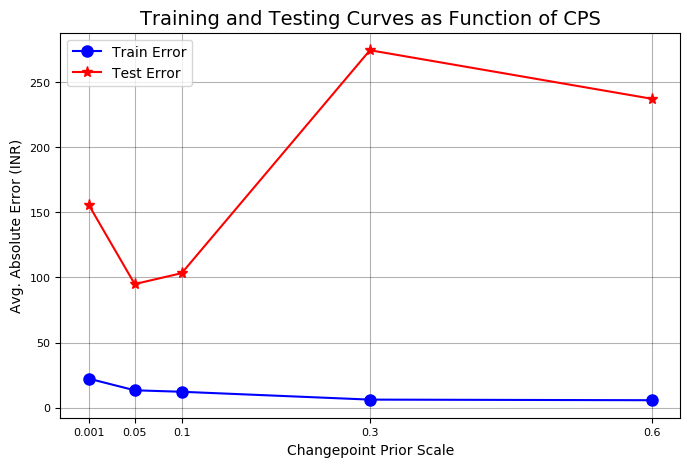

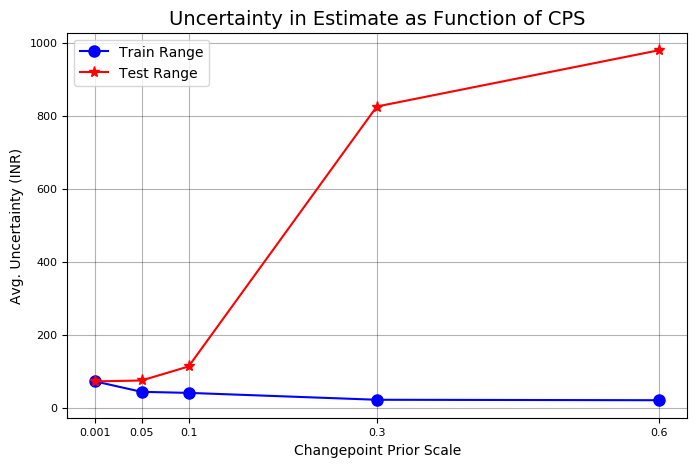

In [15]:
mothersumi.changepoint_prior_validation(start_date = '2014-02-01', end_date = '2015-05-01', changepoint_priors=[0.001,0.05,0.1,0.3,0.6])

# Now evaluating the prediction again 

0.5 seems to be a suitable prior to the model(I tested it several times changing the date range as well as the priors). Hence we set the prior to 0.5 and evaluate.

In [33]:
mothersumi.changepoint_prior_scale = 0.001

C:\Users\133924\Documents\Hitachi Consulting\Financial Analytics\stocker\stocker.py:522: RuntimeWarning: invalid value encountered in sign
  test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1



Prediction Range: 2017-02-20 to 2018-02-20.

Predicted price on 2018-02-17 = INR417.29.
Actual price on    2018-02-16 = INR326.75.

Average Absolute Error on Training Data = INR83.93.
Average Absolute Error on Testing  Data = INR50.72.

When the model predicted an increase, the price increased 54.40% of the time.
When the model predicted a  decrease, the price decreased  45.45% of the time.

The actual value was within the 80% confidence interval 98.38% of the time.


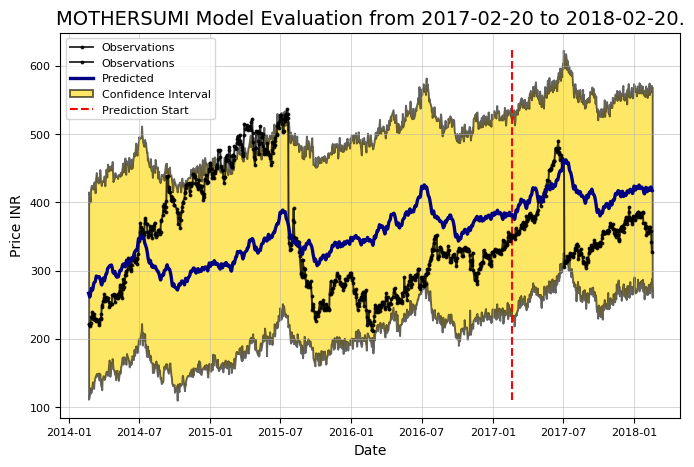

In [34]:
mothersumi.evaluate_prediction()

In [35]:
mothersumi.weekly_seasonality = True

C:\Users\133924\Documents\Hitachi Consulting\Financial Analytics\stocker\stocker.py:522: RuntimeWarning: invalid value encountered in sign
  test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1



Prediction Range: 2017-02-20 to 2018-02-20.

Predicted price on 2018-02-17 = INR193.31.
Actual price on    2018-02-16 = INR326.75.

Average Absolute Error on Training Data = INR67.99.
Average Absolute Error on Testing  Data = INR81.52.

When the model predicted an increase, the price increased 58.25% of the time.
When the model predicted a  decrease, the price decreased  48.25% of the time.

The actual value was within the 80% confidence interval 84.21% of the time.


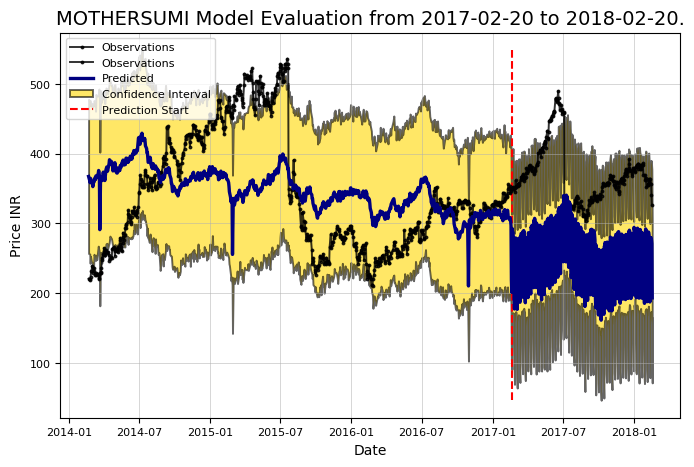

In [36]:
mothersumi.evaluate_prediction()

There we set what is best for our model:

In [37]:
mothersumi.changepoint_prior_scale = 0.001
mothersumi.weekly_seasonality = False

# Finally it's time to play DA GAME!

(Copying the rules of the game from stocker.py- Thanks William.)
Here they are:

We will compare our model with the simple strategy of buying and holding over the same time period. The rules of our game are straightforward:

1. If we predict the price will increase, we buy stock on that day. If we predict a decrease, we do not play the market.
2. If we predicted an increase and the stock does increase, we recieve the change in price of the stock over that day times the number of shares.
3. If we predicted an increase and the stock decreases, we lose the change in price of the stock over that day times the number of shares.

We are assuming the "change in price of a share on that day" is the difference between the previous days' closing price and the closing price on our day. For example, if the closing price on Monday was \$14 and the closing price on Tuesday was \$18, we would call that a \$4 change on Tuesday. This is not entirely accurate as stocks prices change a small amount overnight, but it will be acceptable for our game.

C:\Users\133924\Documents\Hitachi Consulting\Financial Analytics\stocker\stocker.py:522: RuntimeWarning: invalid value encountered in sign
  test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1
C:\Users\133924\Documents\Hitachi Consulting\Financial Analytics\stocker\stocker.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_pred_increase['pred_profit'] = prediction_profit


You played the stock market in MOTHERSUMI from 2017-02-20 to 2018-02-20 with 300 shares.

When the model predicted an increase, the price increased 54.40% of the time.
When the model predicted a  decrease, the price decreased  45.45% of the time.

The total profit using the Prophet model = INR29205.00.
The Buy and Hold strategy profit =         INR-7290.00.

Thanks for playing the stock market!



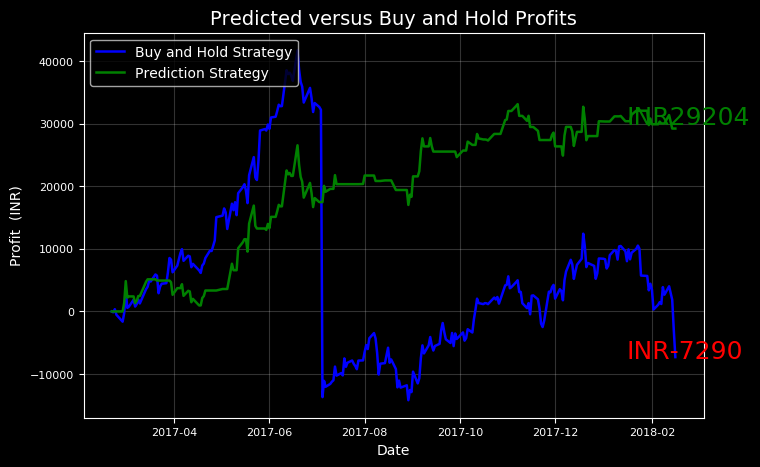

In [21]:
mothersumi.evaluate_prediction(nshares = 300)

Notice that our profits do not depend on the difference between the final predicted price and the actual price, only on the percentage of the time we correctly predicted the direction. 

C:\Users\133924\Documents\Hitachi Consulting\Financial Analytics\stocker\stocker.py:522: RuntimeWarning: invalid value encountered in sign
  test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1
C:\Users\133924\Documents\Hitachi Consulting\Financial Analytics\stocker\stocker.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_pred_increase['pred_profit'] = prediction_profit


You played the stock market in MOTHERSUMI from 2014-06-22 to 2015-03-22 with 300 shares.

When the model predicted an increase, the price increased 53.92% of the time.
When the model predicted a  decrease, the price decreased  51.90% of the time.

The total profit using the Prophet model = INR43755.00.
The Buy and Hold strategy profit =         INR52500.00.

Thanks for playing the stock market!



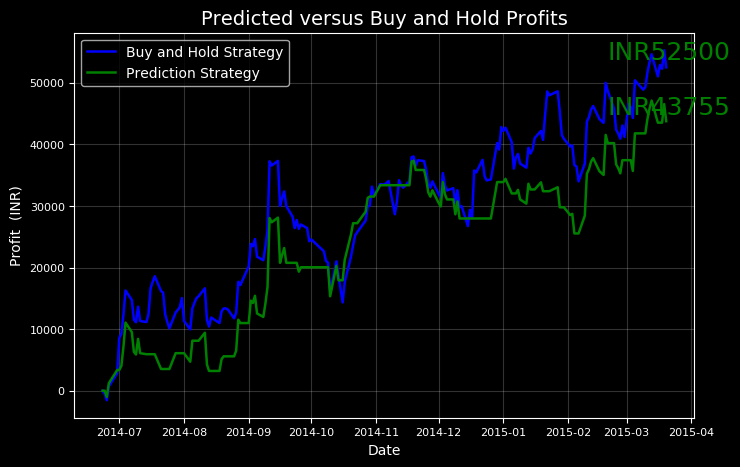

In [22]:
mothersumi.evaluate_prediction(start_date = '2014-06-22', end_date = '2015-03-22', nshares=300)

# Time to predict the future (that's what we want right!)

This function automatically trains on the past 3 years and makes predictions with the uncertainty intervals.


Predicted Increase: 

          Date    estimate     change       upper       lower
5   2018-02-25  297.454718   7.293333  392.474323  207.189023
6   2018-02-26  298.258981   0.804262  391.065914  207.364273
9   2018-03-01  295.462405   1.712327  390.562793  202.937529
10  2018-03-02  301.380538   5.918133  392.719575  209.809835
12  2018-03-04  311.196073   9.815535  403.015912  213.398094
15  2018-03-07  309.047669   1.061381  402.550138  215.337693
16  2018-03-08  314.390159   5.342490  408.110204  218.930474
17  2018-03-09  320.836278   6.446119  420.075041  230.778317
19  2018-03-11  322.095614   1.259336  420.962983  228.623238
22  2018-03-14  322.336009   4.543328  414.452724  230.460515
23  2018-03-15  329.643630   7.307621  421.521960  238.810559
24  2018-03-16  334.906947   5.263318  429.965276  234.982113
28  2018-03-20  330.189355   0.560840  427.601538  241.044774
29  2018-03-21  332.739577   2.550222  423.122046  232.387883
30  2018-03-22  333.913916   1.174339  431.6976

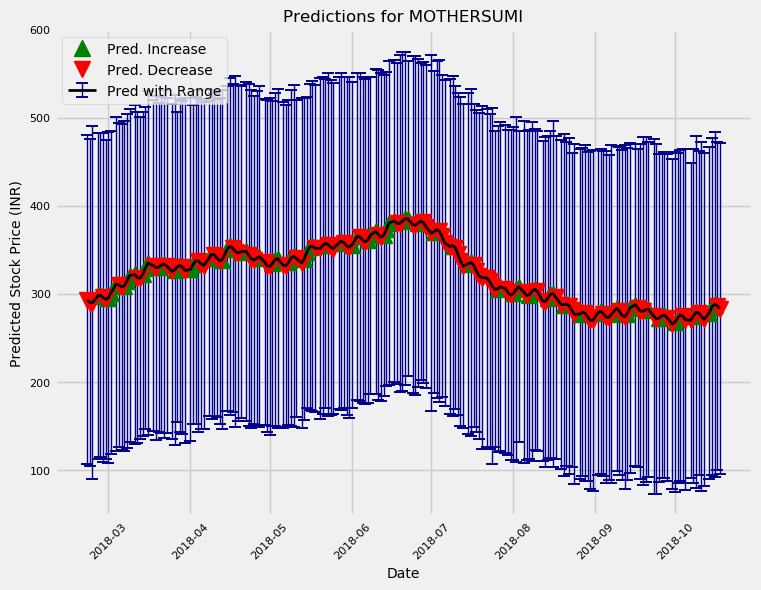

In [39]:
mothersumi.predict_future(days =240)